In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from ray import tune
import numpy as np
import math

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import data from Data/phil_socdata_train.csv, normalize (between 0 and 1) and standardize
train_data = TabularDataset('Data/phil_socdata_train.csv')

# drop the "T" column as it doesnt help with the prediction
train_data = train_data.drop(labels=['T'],axis=1)
train_data.head()


,SOC,V,I,P,V_avg_five,V_avg_one,I_avg
0,100.000031,400.125,-1.50,-600.187500,400.125,400.125,-1.50
1,100.000031,400.125,-1.56,-624.195042,400.125,400.125,-1.53
2,100.000031,400.125,-1.62,-648.202585,400.125,400.125,-1.56
3,100.000031,400.125,-1.68,-672.210127,400.125,400.125,-1.59
4,100.000031,400.125,-1.74,-696.217669,400.125,400.125,-1.62


<Axes: >

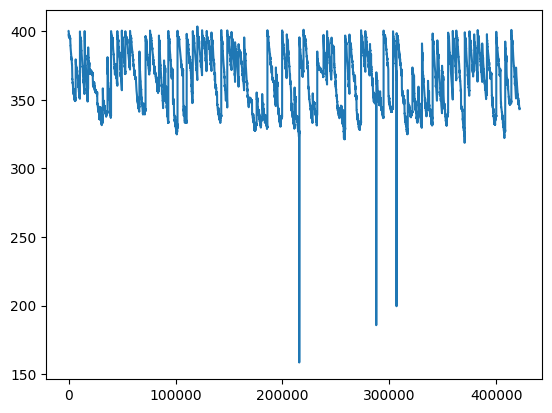

In [41]:
# plot V
train_data['V_avg_one'].plot()

In [ ]:
import pandas as pd
# create a data fram with 3 values, 1,2,3
df = pd.DataFrame({'A': [1, 2, 3]})
print(df)

for x in range(len(df)):
    if x ==1:
        df.drop(x)

In [4]:
label = 'SOC'
train_data[label].describe()

count    421697.000000
mean         68.185519
std          24.502969
min           0.000000
25%          49.019623
50%          73.333359
75%          89.019638
max         100.000031
Name: SOC, dtype: float64

In [23]:
time_limit = 60  # train various models for x minutes

predictor = TabularPredictor(label=label,eval_metric='mean_squared_error').fit(
    train_data, 
    time_limit=time_limit, 
    presets=['best_quality','optimize_for_deployment']
)



No path specified. Models will be saved in: "AutogluonModels/ag-20230415_174220/"
Presets specified: ['best_quality', 'optimize_for_deployment']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20230415_174220/"
AutoGluon Version:  0.7.0
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #148-Ubuntu SMP Mon Oct 17 16:02:06 UTC 2022
Train Data Rows:    421697
Train Data Columns: 6
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 68.18552, 24.50297)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: 

In [24]:
# import test data from Data/phil_socdata_test.csv, normalize (between 0 and 1) and standardize
test_data1 = TabularDataset(f'Data/phil_socdata_test1.csv')
test_data2 = TabularDataset(f'Data/phil_socdata_test2.csv')

y_pred1= predictor.predict(test_data1.drop(columns=[label]))
y_pred1.head()

y_pred2= predictor.predict(test_data2.drop(columns=[label]))
y_pred2.head()

Loaded data from: Data/phil_socdata_test1.csv | Columns = 8 / 8 | Rows = 18307 -> 18307
Loaded data from: Data/phil_socdata_test2.csv | Columns = 8 / 8 | Rows = 5617 -> 5617


0    50.307056
1    49.949825
2    49.949825
3    50.540142
4    50.540142
Name: SOC, dtype: float32

In [25]:
predictor.evaluate(test_data1, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'mean_squared_error': -4.581466513750035,
 'root_mean_squared_error': -2.140436056916916,
 'mean_absolute_error': -1.6648037272267027,
 'r2': 0.9929146899156276,
 'pearsonr': 0.9982876157882918,
 'median_absolute_error': -1.3406753551367245}

In [26]:
predictor.evaluate(test_data2, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'mean_squared_error': -1.398577496027333,
 'root_mean_squared_error': -1.1826146862048235,
 'mean_absolute_error': -0.8574618260044922,
 'r2': 0.9923509194974013,
 'pearsonr': 0.9962154486804569,
 'median_absolute_error': -0.615955349433591}

In [27]:
predictor.leaderboard(test_data1, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-4.581467,-3.884412,0.765576,13.521142,14.430364,0.765576,13.521142,14.430364,1,True,1
1,WeightedEnsemble_L2,-4.581467,-3.884412,0.767494,13.524966,14.437875,0.001918,0.003824,0.007511,2,True,2


In [28]:
predictor.leaderboard(test_data2, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-1.398577,-3.884412,0.413919,13.521142,14.430364,0.413919,13.521142,14.430364,1,True,1
1,WeightedEnsemble_L2,-1.398577,-3.884412,0.415628,13.524966,14.437875,0.001709,0.003824,0.007511,2,True,2


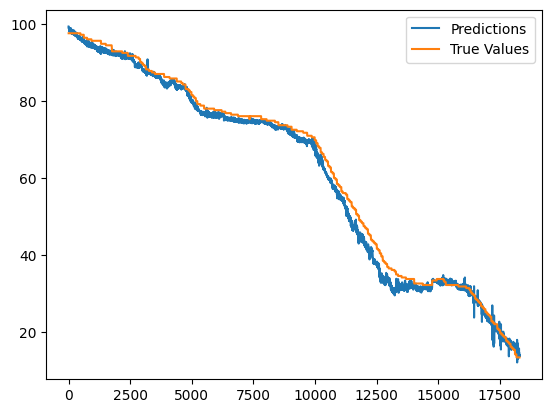

In [29]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred1, label="Predictions")
plt.plot(test_data1[label], label="True Values")
plt.legend()
plt.show()

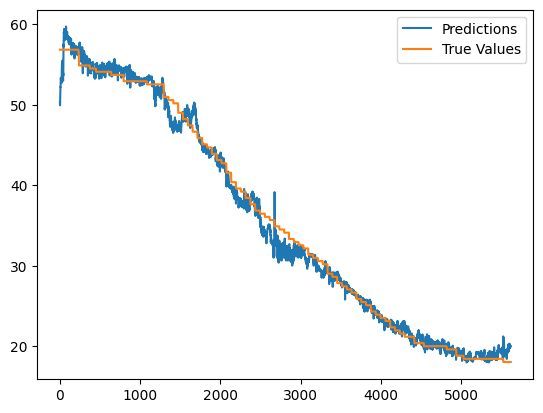

In [30]:
plt.plot(y_pred2, label="Predictions")
plt.plot(test_data2[label], label="True Values")
plt.legend()
plt.show()

In [31]:
mse_test = np.mean(((y_pred1 - test_data1[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 1 RMSE", rmse_test)
mse_test = np.mean(((y_pred2 - test_data2[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 2 RMSE", rmse_test)

Test data 1 RMSE 2.140436056916916
Test data 2 RMSE 1.1826146862048235


In [32]:
predictor.feature_importance(test_data1)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 6 features using 5000 rows with 5 shuffle sets...
	16.77s	= Expected runtime (3.35s per shuffle set)
	7.04s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg_five,675.752061,12.661969,1.478541e-08,5,701.823230,649.680892
V,295.095673,7.127422,4.080581e-08,5,309.771133,280.420213
V_avg_one,84.649480,1.239164,5.509024e-09,5,87.200935,82.098025
I_avg,36.400014,1.133039,1.125108e-07,5,38.732957,34.067070
P,4.138757,0.087156,2.358460e-08,5,4.318211,3.959302
I,1.465996,0.021916,5.991373e-09,5,1.511120,1.420872


In [33]:
predictor.feature_importance(test_data2)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 6 features using 5000 rows with 5 shuffle sets...
	13.15s	= Expected runtime (2.63s per shuffle set)
	6.81s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg_five,210.141072,8.613706,3.380067e-07,5,227.876812,192.405333
I_avg,37.618426,0.525852,4.580556e-09,5,38.701162,36.535690
V,33.420285,1.312610,2.849646e-07,5,36.122967,30.717603
V_avg_one,16.785205,0.697160,3.562922e-07,5,18.220667,15.349743
P,5.135252,0.100829,1.782627e-08,5,5.342861,4.927643
I,0.969579,0.032027,1.426594e-07,5,1.035524,0.903635


In [34]:
# save the model to the Models folder
predictor.save('Models/autogluon_SOC')



In [39]:
import pandas as pd

# save predicted values and actual values to a new df
df = pd.DataFrame({'Predicted': y_pred1, 'Actual': test_data1[label]})

# save the df to a csv file
df.to_csv('Data/autogluon_soc_pred1.csv', index=False)

# save predicted values and actual values to a new df
df = pd.DataFrame({'Predicted': y_pred2, 'Actual': test_data2[label]})

# save the df to a csv file
df.to_csv('Data/autogluon_soc_pred2.csv', index=False)